In [1]:
import scanpy as sc 
import numpy as np
import pandas as pd  
import GEOparse as geo
from pathlib import Path

In [2]:
file_path = "/Users/derekmartinez/Desktop/ECBM4060/GSE174188_CLUES1_adjusted.h5ad"
adata = sc.read_h5ad(file_path)

In [3]:
adata = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs)

In [4]:
adata.var = adata.var.drop(columns=["feature_types-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0"])

In [5]:
adata

AnnData object with n_obs × n_vars = 1263676 × 32738
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'

In [6]:
adata = sc.pp.subsample(adata, n_obs=120_000, copy=True)

In [7]:
adata

AnnData object with n_obs × n_vars = 120000 × 32738
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'

In [20]:
adata_t = adata[(adata[:,'CD3D'].X > 0)]

In [21]:
adata_t

View of AnnData object with n_obs × n_vars = 52616 × 32738
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'

In [22]:
sc.pp.normalize_total(adata_t, inplace=True)

/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [23]:
sc.pp.log1p(adata_t)

In [24]:
mean_expr = pd.Series(adata_t.X.mean(axis=0).A1 if hasattr(adata_t.X.mean(axis=0), 'A1') else adata_t.X.mean(axis=0).ravel())
mean_expr.index = adata_t.var.index
mean_expr.describe()

count    32738.000000
mean         0.022983
std          0.148210
min          0.000000
25%          0.000000
50%          0.000145
75%          0.007136
max          5.130014
dtype: float64

In [25]:
adata_t = adata_t[:, mean_expr[mean_expr >= 0.000145].index]

In [26]:
adata_t

View of AnnData object with n_obs × n_vars = 52616 × 16363
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'log1p'

In [28]:
sc.tl.pca(adata_t)

/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [29]:
sc.pp.neighbors(adata_t, random_state=0)

In [30]:
sc.settings.verbosity = 3
sc.tl.umap(adata_t, random_state=0,)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:35)


In [31]:
sc.tl.leiden(adata_t)

running Leiden clustering


/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_80555/1995543966.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_t)


    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:45)


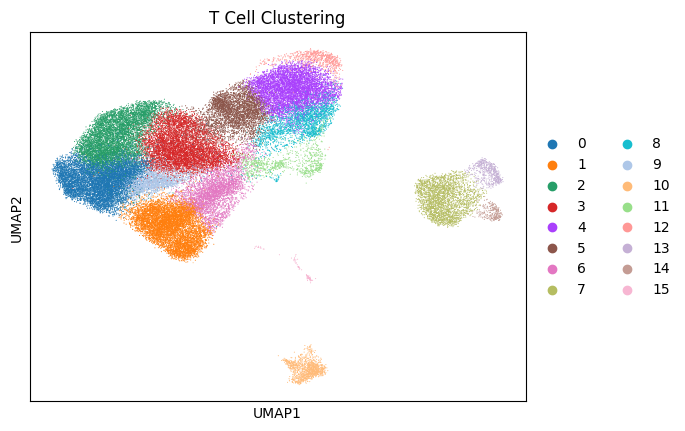

In [32]:
sc.pl.umap(adata_t, color= 'leiden', cmap='turbo', title = 'T Cell Clustering')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


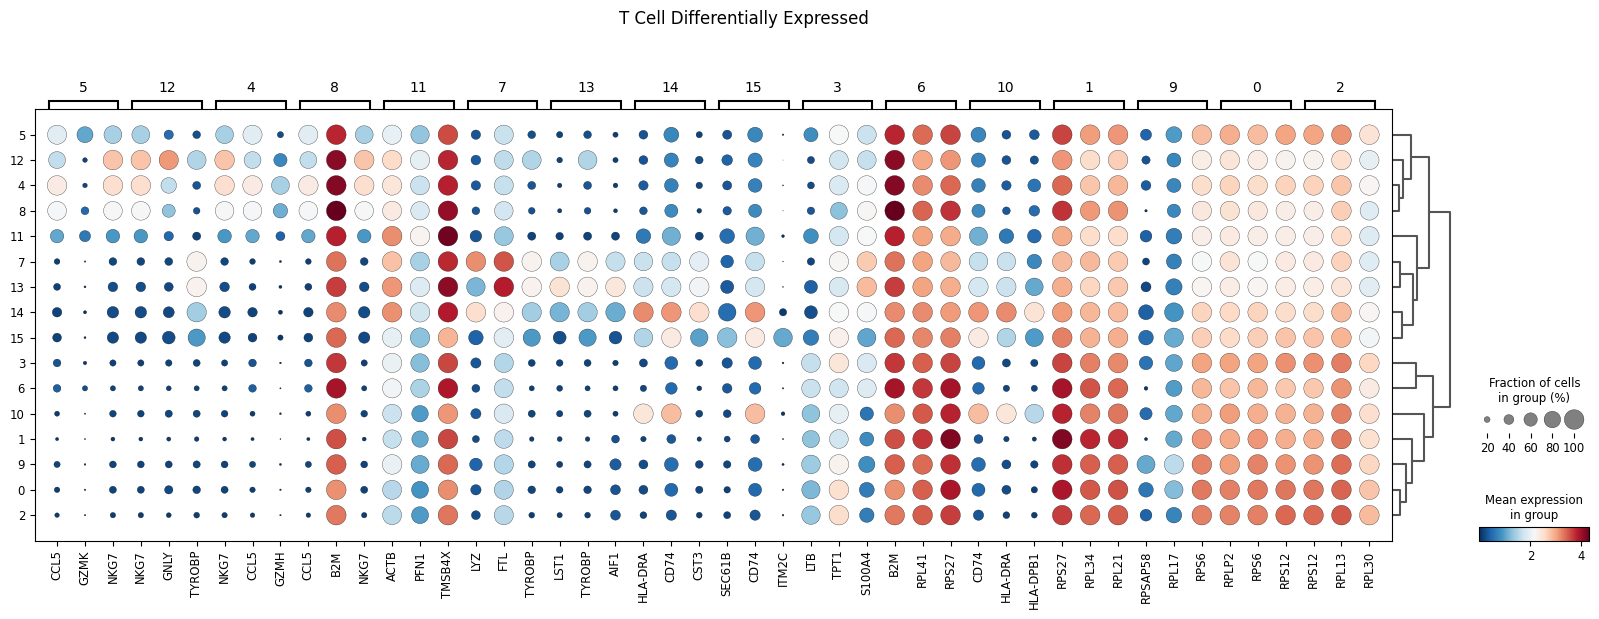

In [75]:
sc.tl.rank_genes_groups(adata_t, "leiden", method="t-test")
sc.pl.rank_genes_groups_dotplot(adata_t, n_genes=3, title='T Cell Differentially Expressed', cmap='RdBu_r')

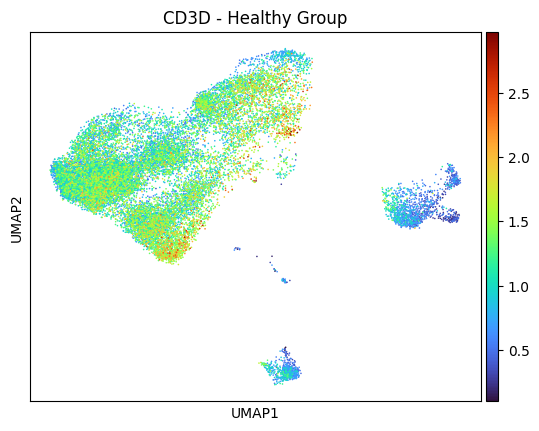

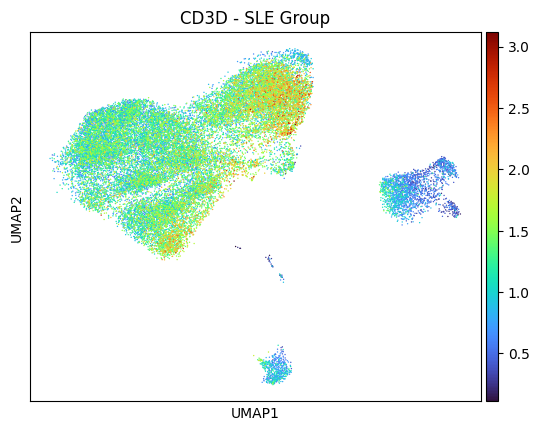

In [35]:
for group in ['Healthy', "SLE"]:
    adata_group = adata_t[adata_t.obs['SLE_status'] == group]
    
    # Plot UMAP for each group
    # sc.pl.umap(adata_group, color=['celltype'], title=f'UMAP - {group} Group', cmap='turbo')
    sc.pl.umap(
    adata_group,
    color= 'CD3D',
    title=f'CD3D - {group} Group',
    cmap='turbo', # Show legends directly on the UMAP
    show=False             # Prevent immediate display
)

In [24]:
# count_t = adata_t.obs['SLE_status'].value_counts()
count_all = adata.obs['SLE_status'].value_counts()

In [39]:
count_t

SLE_status
SLE        30263
Healthy    22353
Name: count, dtype: int64

In [25]:
count_all

SLE_status
SLE        73869
Healthy    46131
Name: count, dtype: int64

In [41]:
t_percentage_healthy = count_t[1]/count_all[1]
t_percentage_SLE = count_t[0]/count_all[0]

print("T Cell percentage in healthy group: {}".format(t_percentage_healthy))
print("T Cell percentage in SLE group: {}".format(t_percentage_SLE))

T Cell percentage in healthy group: 0.48455485465305326
T Cell percentage in SLE group: 0.4096847121255195


/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_80555/3701118039.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_percentage_healthy = count_t[1]/count_all[1]
/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_80555/3701118039.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_percentage_SLE = count_t[0]/count_all[0]


SLE_status
SLE        30263
Healthy    22353
Name: count, dtype: int64
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


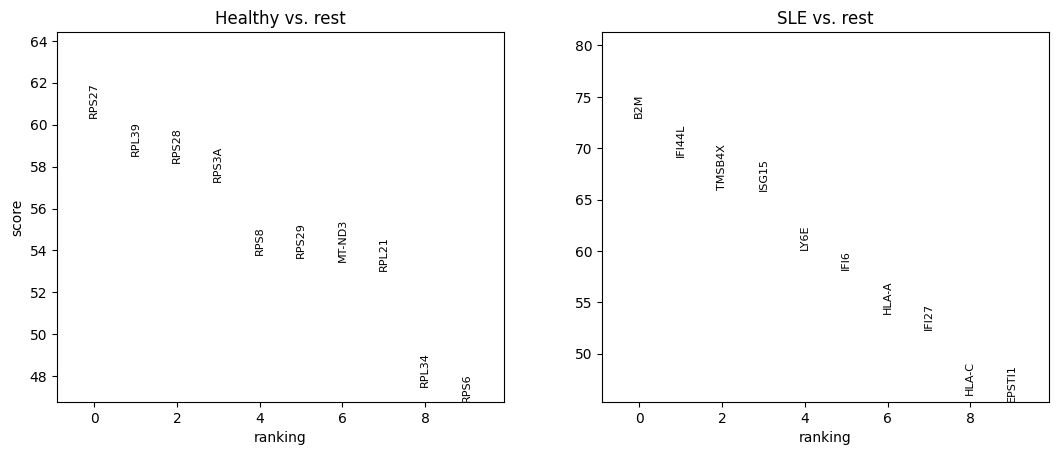

In [43]:
print(adata_t.obs['SLE_status'].value_counts())
sc.tl.rank_genes_groups(adata_t, groupby='SLE_status', method='t-test')
sc.pl.rank_genes_groups(adata_t, n_genes=10, sharey=False)

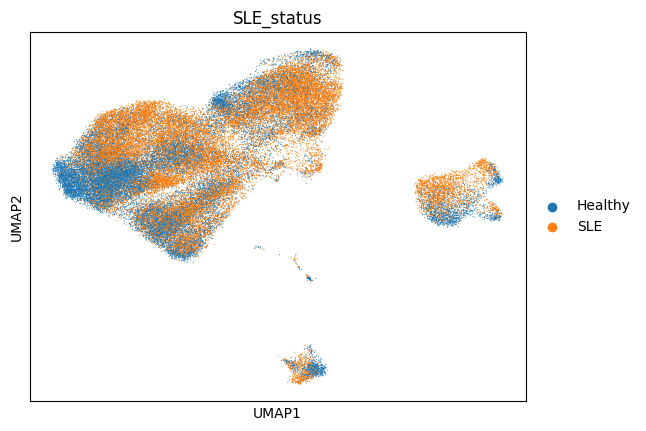

In [44]:
sc.pl.umap(adata_t, color= 'SLE_status', cmap='turbo')

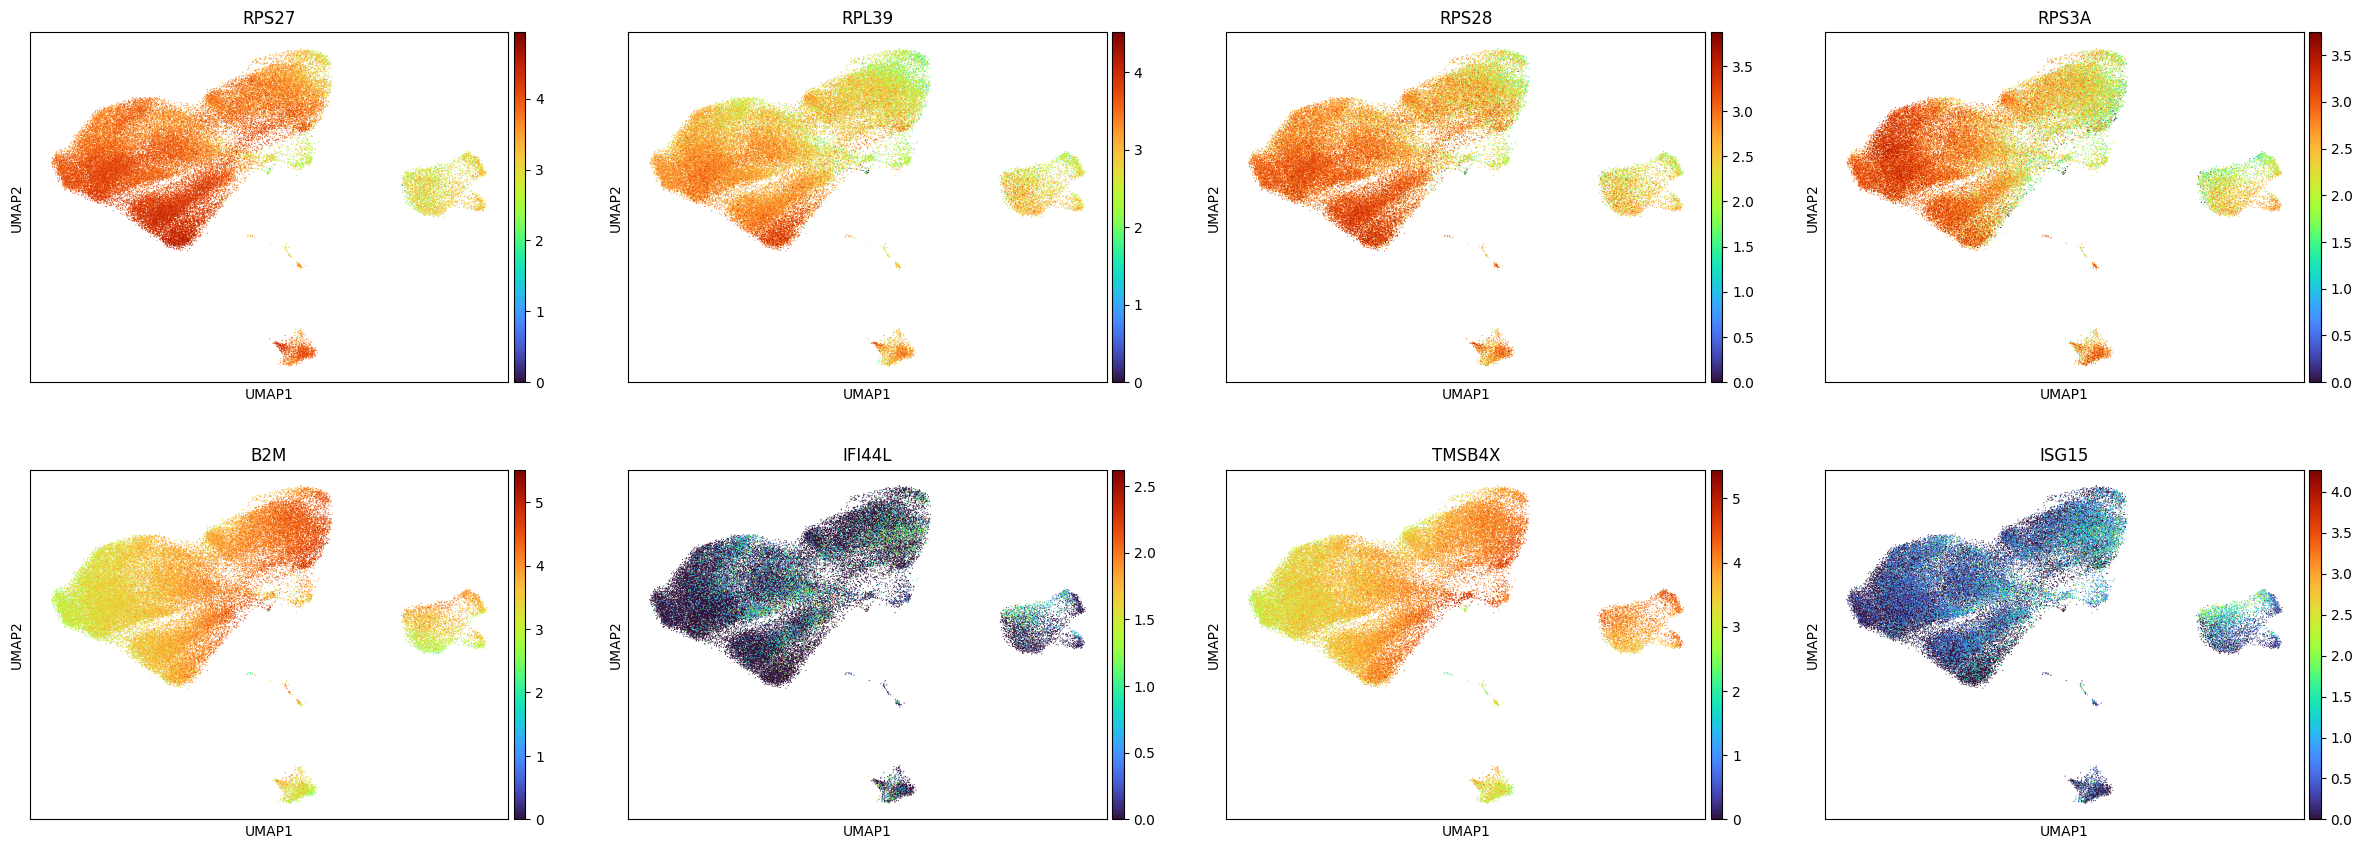

In [45]:
sc.pl.umap(adata_t, color= ['RPS27', 'RPL39', 'RPS28', 'RPS3A', 'B2M', 'IFI44L', 'TMSB4X', 'ISG15'], cmap='turbo')

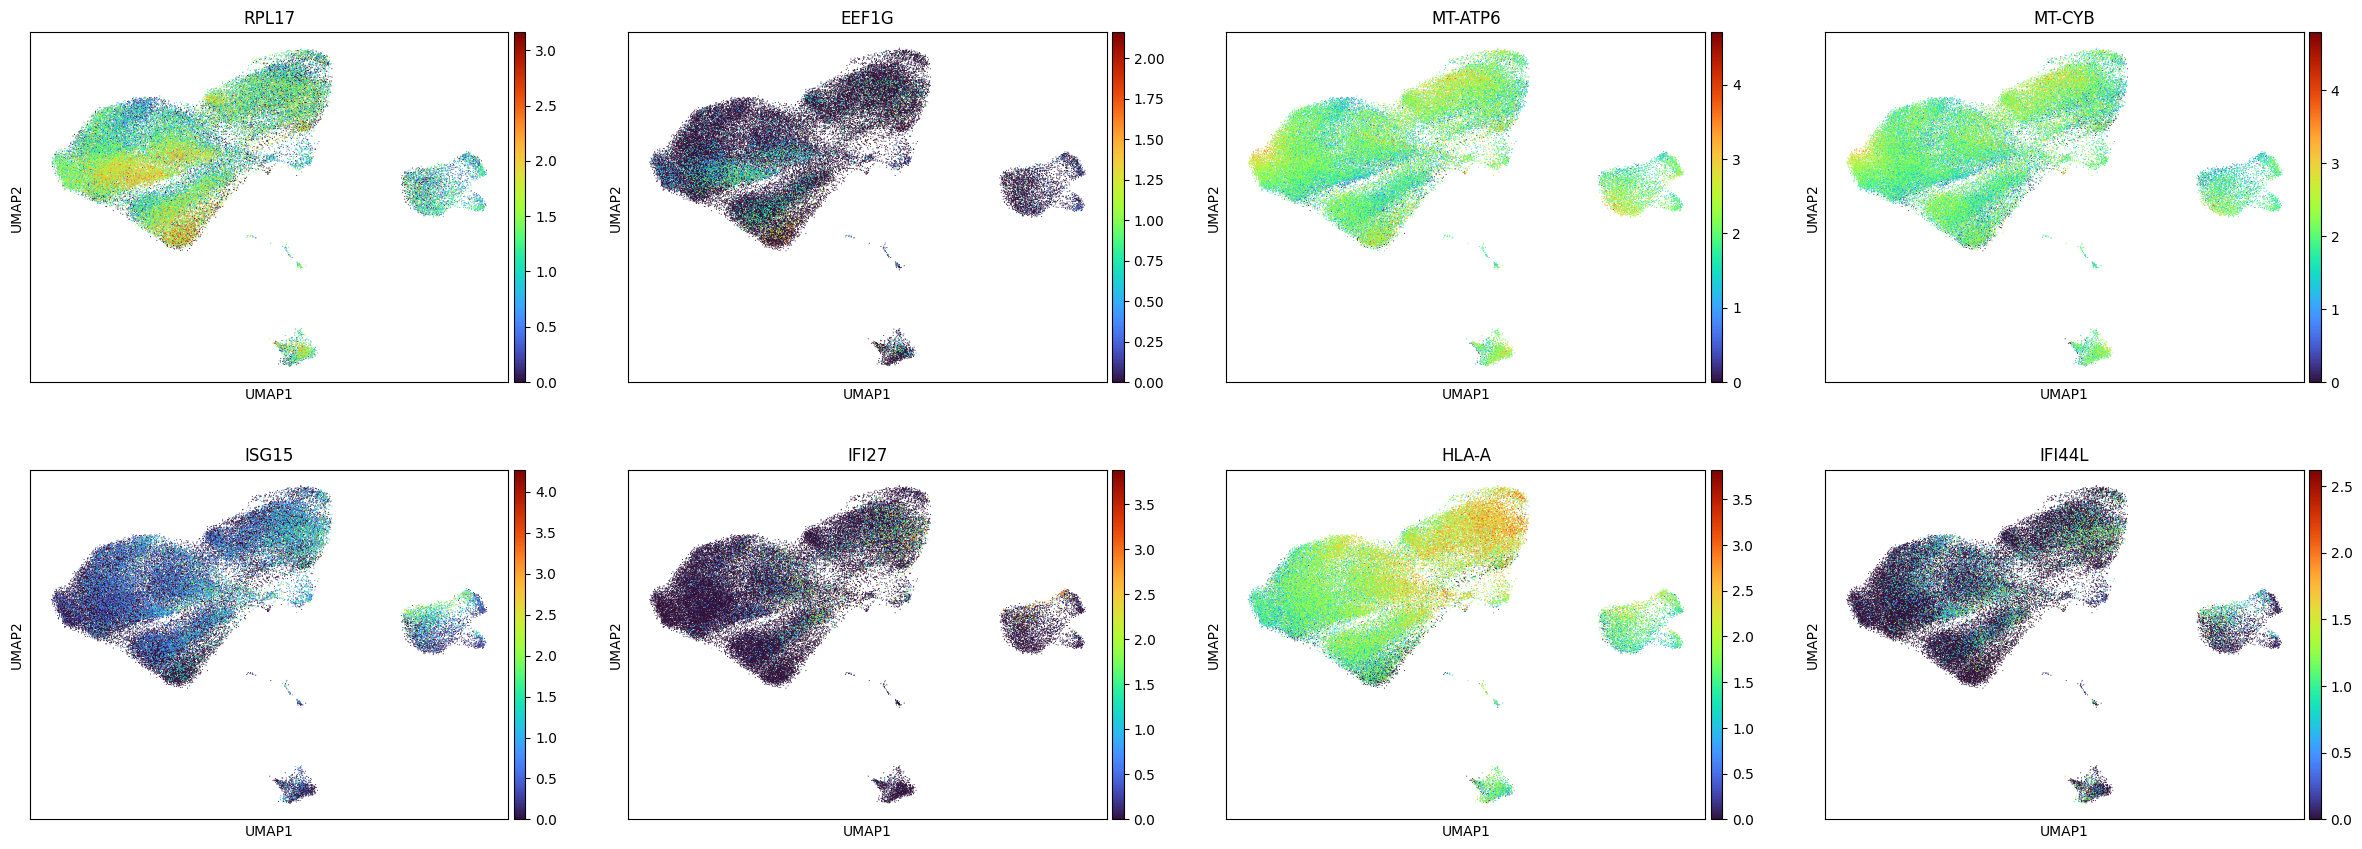

In [46]:
sc.pl.umap(adata_t, color= ['RPL17', 'EEF1G', 'MT-ATP6', 'MT-CYB','ISG15', 'IFI27', 'HLA-A', 'IFI44L'], cmap='turbo')

In [8]:
adata_b = adata[(adata[:,'MS4A1'].X > 0)]

In [9]:
adata_b

View of AnnData object with n_obs × n_vars = 13166 × 32738
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'

In [10]:
sc.pp.normalize_total(adata_b, inplace=True)

/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
sc.pp.log1p(adata_b)

In [12]:
mean_expr_b = pd.Series(adata_b.X.mean(axis=0).A1 if hasattr(adata_b.X.mean(axis=0), 'A1') else adata_b.X.mean(axis=0).ravel())
mean_expr_b.index = adata_b.var.index
mean_expr_b.describe()

count    32738.000000
mean         0.022440
std          0.146459
min          0.000000
25%          0.000000
50%          0.000150
75%          0.007304
max          4.955344
dtype: float64

In [15]:
# Ensure CD19 is always included, even if its mean expression is below the threshold
genes_to_include = mean_expr_b[mean_expr_b >= 0.000150].index.tolist()
genes_to_include.append('CD19')
genes_to_include.append('CD1D')
genes_to_include.append('SPN')
genes_to_include.append('CR2')
genes_to_include.append('FCER2')


# Remove duplicates in case 'CD19' is already included
genes_to_include = list(set(genes_to_include))

# Subset the AnnData object
adata_b = adata_b[:, genes_to_include]


In [16]:
adata_b

View of AnnData object with n_obs × n_vars = 13166 × 16368
    obs: 'batch_cov', 'ind_cov', 'Processing_Cohort', 'louvain', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status'
    var: 'gene_ids'
    uns: 'log1p'

In [17]:
sc.tl.pca(adata_b)

/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [18]:
sc.pp.neighbors(adata_b, random_state=0)

In [19]:
sc.settings.verbosity = 3
sc.tl.umap(adata_b, random_state=0,)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:09)


In [20]:
sc.tl.leiden(adata_b)

running Leiden clustering


/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_94769/2925326579.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_b)


    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:10)


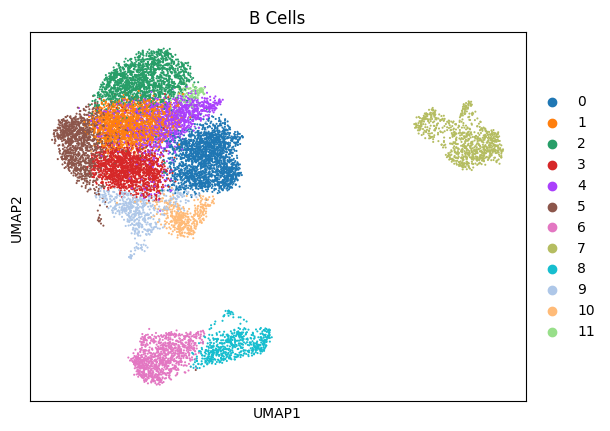

In [21]:
sc.pl.umap(adata_b, color= 'leiden', cmap='turbo', title = 'B Cells')

In [22]:
count_b = adata_b.obs['SLE_status'].value_counts()
count_b

SLE_status
SLE        7641
Healthy    5525
Name: count, dtype: int64

In [26]:
b_percentage_healthy = count_b[1]/count_all[1]
b_percentage_SLE = count_b[0]/count_all[0]

print("B Cell percentage in healthy group: {}".format(b_percentage_healthy))
print("B Cell percentage in SLE group: {}".format(b_percentage_SLE))

B Cell percentage in healthy group: 0.119767618304394
B Cell percentage in SLE group: 0.10343987328920115


/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_94769/3253326991.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_percentage_healthy = count_b[1]/count_all[1]
/var/folders/66/xf6391m10_1_0gt7tbm34_7r0000gn/T/ipykernel_94769/3253326991.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b_percentage_SLE = count_b[0]/count_all[0]


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


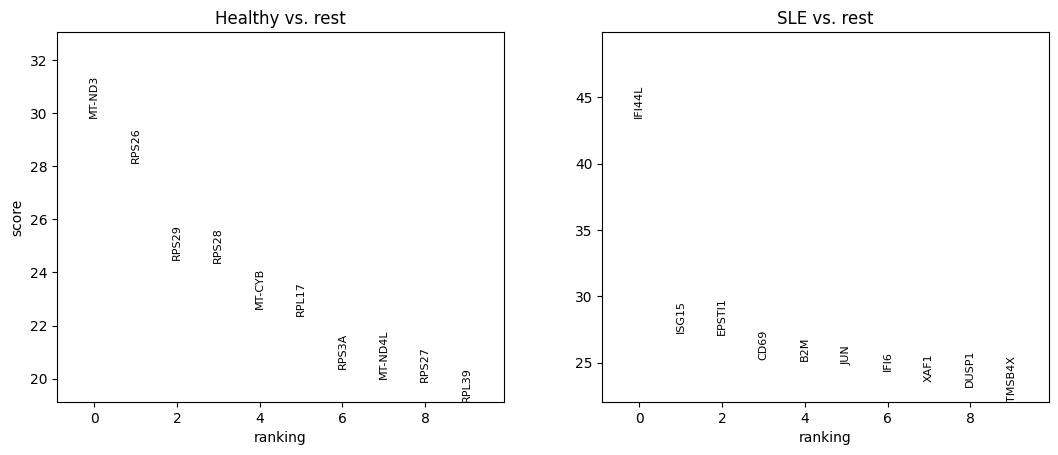

In [27]:
sc.tl.rank_genes_groups(adata_b, groupby='SLE_status', method='t-test')
sc.pl.rank_genes_groups(adata_b, n_genes=10, sharey=False)

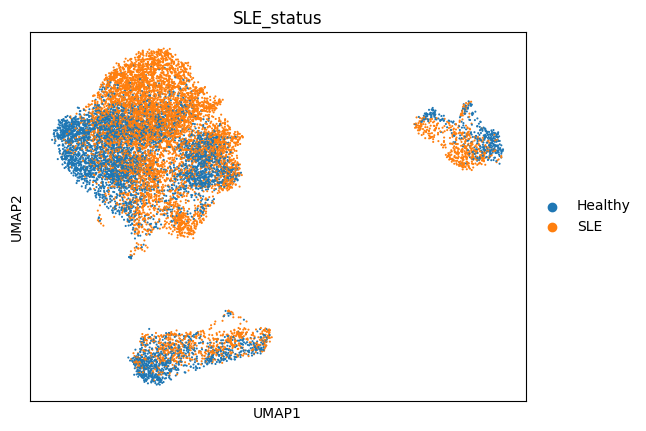

In [28]:
sc.pl.umap(adata_b, color= 'SLE_status', cmap='turbo')

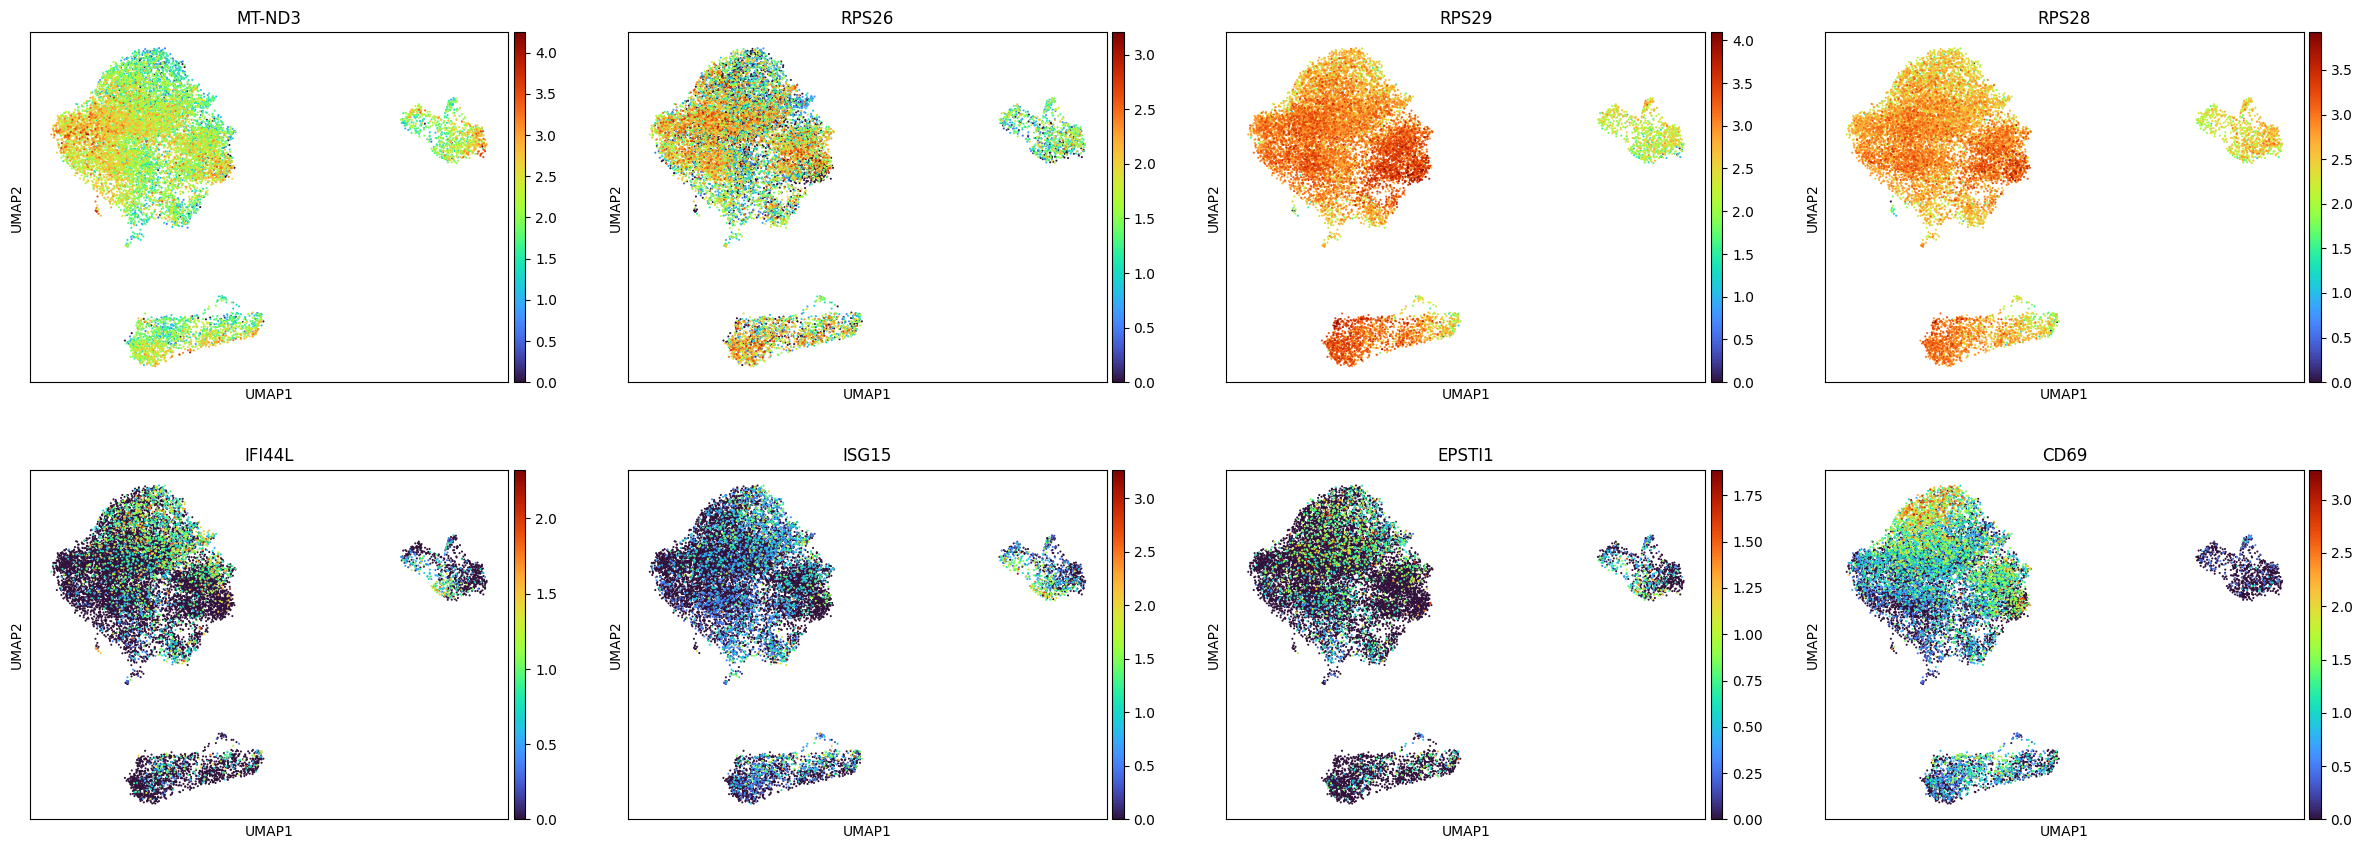

In [29]:
sc.pl.umap(adata_b, color= ['MT-ND3', 'RPS26', 'RPS29', 'RPS28', 'IFI44L', 'ISG15', 'EPSTI1', 'CD69'], cmap='turbo')

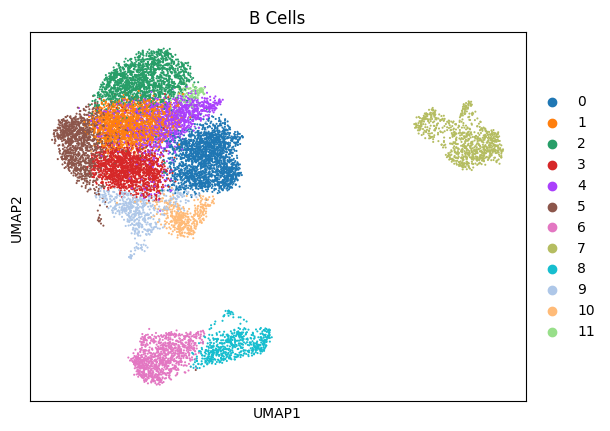

In [30]:
sc.pl.umap(adata_b, color= 'leiden', cmap='turbo', title = 'B Cells')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


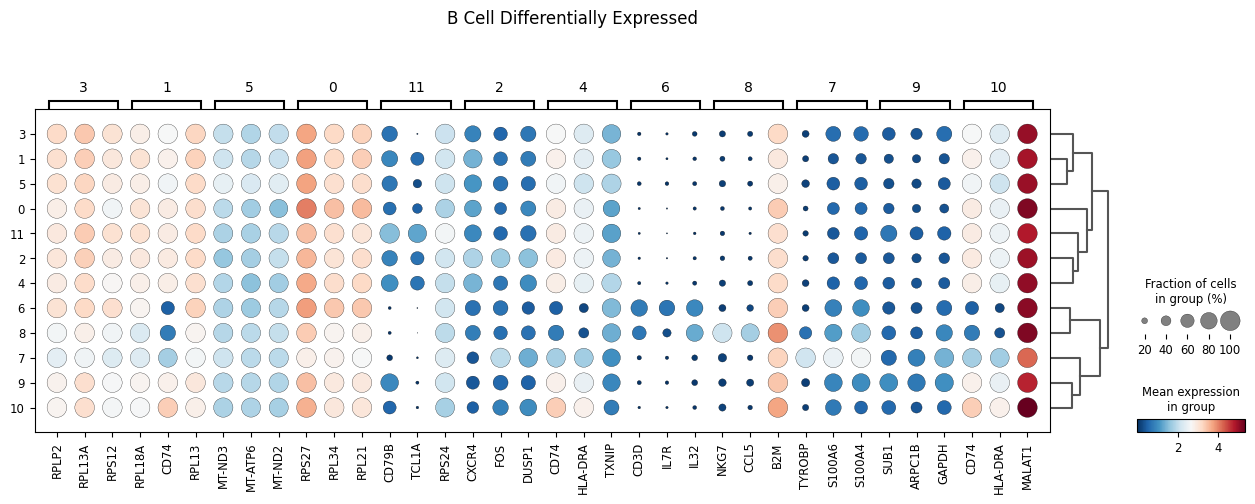

In [31]:
sc.tl.rank_genes_groups(adata_b, "leiden", method="t-test")
sc.pl.rank_genes_groups_dotplot(adata_b, n_genes=3, title='B Cell Differentially Expressed', cmap='RdBu_r')

In [ ]:
# Retrieve the results from the 'rank_genes_groups' analysis
ranked_genes = adata_b.uns['rank_genes_groups']

# Print the top 3 genes for each cluster
for cluster in ranked_genes['names'].dtype.names:
    print(f"Top 3 genes for cluster {cluster}:")
    print(ranked_genes['names'][cluster][:3])  # Get top 3 genes for each cluster
    print()

Top 3 genes for cluster 0:
['RPS27' 'RPL34' 'RPL21']

Top 3 genes for cluster 1:
['RPL18A' 'CD74' 'RPL13']

Top 3 genes for cluster 2:
['CXCR4' 'FOS' 'DUSP1']

Top 3 genes for cluster 3:
['RPLP2' 'RPL13A' 'RPS12']

Top 3 genes for cluster 4:
['CD74' 'HLA-DRA' 'TXNIP']

Top 3 genes for cluster 5:
['MT-ND3' 'MT-ATP6' 'MT-ND2']

Top 3 genes for cluster 6:
['CD3D' 'IL7R' 'IL32']

Top 3 genes for cluster 7:
['TYROBP' 'S100A6' 'S100A4']

Top 3 genes for cluster 8:
['NKG7' 'CCL5' 'B2M']

Top 3 genes for cluster 9:
['SUB1' 'ARPC1B' 'GAPDH']

Top 3 genes for cluster 10:
['CD74' 'HLA-DRA' 'MALAT1']

Top 3 genes for cluster 11:
['CD79B' 'TCL1A' 'RPS24']



In [33]:
celltype = {'celltype':[],}
celltype['celltype'] = [
    'B.RPS27-RPL34-RPL21' if str(leiden) == '0' else 
    'B.RPL18A-CD74-RPL13' if str(leiden) == '1' else
    'B.CXCR4-FOS-DUSP1' if str(leiden) == '2' else 
    'B.RPLP2-RPL13A-RPS12' if str(leiden) == '3' else
    'B.CD74-HLADRA-TXNIP' if str(leiden) == '4' else
    'B.MTND3-MTATP6-MTND2' if str(leiden) == '5' else
    'B.CD3D-IL7R-IL32' if str(leiden) == '6' else
    'B.TYROBP-S100A6-S100A4' if str(leiden) == '7' else
    'B.NKG7-CCL5-B2M4' if str(leiden) == '8' else
    'B.SUB1-ARPC1B-GAPDH' if str(leiden) == '9' else
    'B.CD74-HLADRA-MALAT1' if str(leiden) == '10' else 
    'B.CD79B-TCL1A-RPS24' if str(leiden) == '11' else 
    None
    for leiden in adata_b.obs['leiden']
]

In [34]:
df_celltypes = pd.DataFrame(celltype)

In [35]:
df_celltypes.index = adata_b.obs.index

In [36]:
adata_b.obs['celltype'] = df_celltypes["celltype"]

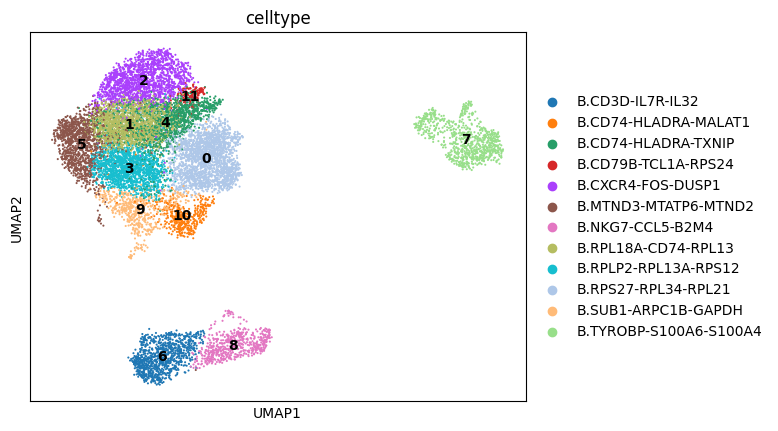

In [ ]:
import scanpy as sc
import matplotlib.pyplot as plt

# Plot the UMAP
sc.pl.umap(
    adata_b,
    color=['celltype'],
    cmap='turbo', # Show legends directly on the UMAP
    show=False             # Prevent immediate display
)

# Add cluster labels
ax = plt.gca()  # Get current axis
for cluster in adata_b.obs['leiden'].cat.categories:
    # Find the coordinates of cells in this cluster
    cluster_mask = adata_b.obs['leiden'] == cluster
    cluster_coords = adata_b.obsm['X_umap'][cluster_mask]
    # Calculate cluster centroid
    x, y = cluster_coords[:, 0].mean(), cluster_coords[:, 1].mean()
    # Add text label
    ax.text(x, y, cluster, color='black', fontsize=10, weight='bold', ha='center', va='center')

# Display the plot
plt.show()

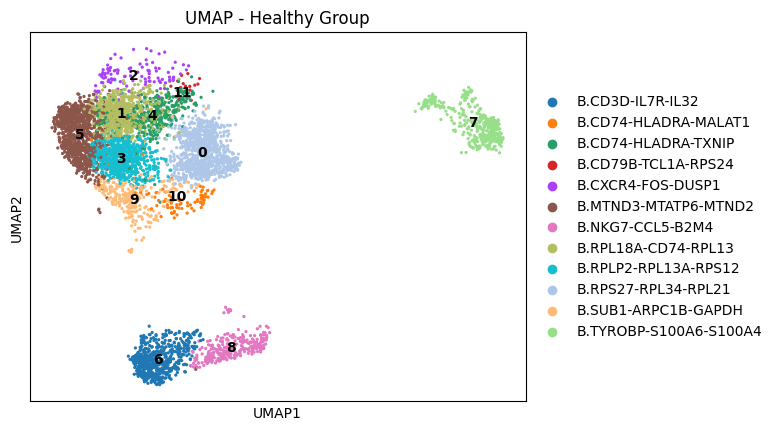

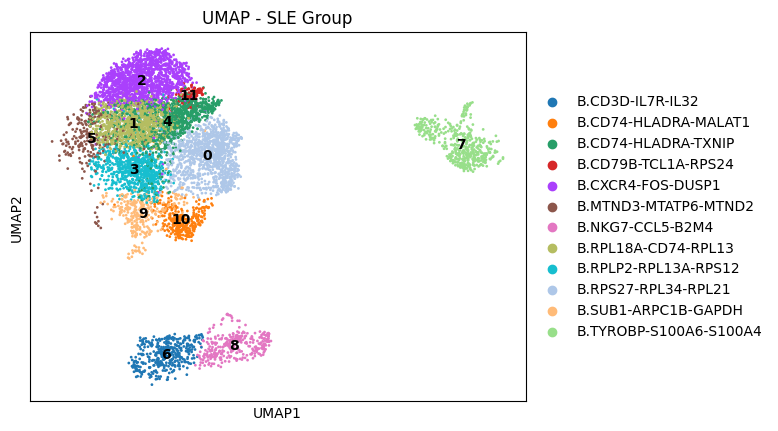

In [39]:
for group in ['Healthy', 'SLE']:
    adata_group = adata_b[adata_b.obs['SLE_status'] == group]
    
    # Plot UMAP for each group
    # sc.pl.umap(adata_group, color=['celltype'], title=f'UMAP - {group} Group', cmap='turbo')
    sc.pl.umap(
    adata_group,
    color=['celltype'],
    title=f'UMAP - {group} Group',
    cmap='turbo', # Show legends directly on the UMAP
    show=False             # Prevent immediate display
)

# Add cluster labels
    ax = plt.gca()  # Get current axis
    for cluster in adata_group.obs['leiden'].cat.categories:
        # Find the coordinates of cells in this cluster
        cluster_mask = adata_group.obs['leiden'] == cluster
        cluster_coords = adata_group.obsm['X_umap'][cluster_mask]
        # Calculate cluster centroid
        x, y = cluster_coords[:, 0].mean(), cluster_coords[:, 1].mean()
        # Add text label
        ax.text(x, y, cluster, color='black', fontsize=10, weight='bold', ha='center', va='center')

    # Display the plot
    plt.show()